In [63]:
import os
import sys
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.notebook import tqdm
from collections import namedtuple
from collections import defaultdict
from pprint import pprint
import pickle

# Configure display options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
%config InlineBackend.figure_format = 'retina'

# Add project directory to sys.path
# pdir = os.path.abspath(os.path.join(os.getcwd(), '.'))
# sys.path.insert(1, pdir)
# from myutils import *

# Other module imports
import ast, math, swifter, csv, json, itertools as it, portion as P

# Set plot style
# plt.style.use('ggplot')

# Function Definitions

In [64]:
import numpy as np
import pandas as pd
import datetime as dt
from collections import namedtuple
import ast, swifter

# ************************************************* Sheng-Ru Latest Version (09-25) add try except (10-27) *************************************************

def parse_mi_ho(df, tz=8):

    # df = pd.read_csv(f)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=tz))
    nr_pci = 'O'
    scells = []

    def NR_OTA(idx):

        if df["type_id"].iloc[idx] == "5G_NR_RRC_OTA_Packet": return True
        else: return False
    
    def LTE_SERV_INFO(idx):

        if df["type_id"].iloc[idx] == "LTE_RRC_Serv_Cell_Info": return True
        else: return False
    

    def find_1st_after(start_idx, target, look_after=1):
        for j in range(start_idx, len(df)):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before(start_idx, target, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before_with_special_value(start_idx, target, target_value, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] in [target_value] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_in_D_exact(targets):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.start).total_seconds(), target))

        if len(l) != 0:
            for x in l:
                if (x[0]== 0):
                    return x[1]
        
        return None
    
    def find_in_D_first_before(targets, look_before=1):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                try:
                    l.append(((t - ho.end).total_seconds(), target, ho))
                except:
                    pass

        if len(l) != 0:
            closest = min(filter(lambda x: x[0] > 0, l), key=lambda x: x[0])
            if 0 <= closest[0] < look_before:
                return closest[1], closest[2]
        
        return None, None
    
    HO = namedtuple('HO',['start', 'end', 'others', 'trans'], defaults=[None,None,'',''])
    
    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'MN_HO_to_eNB': [], # LTE + NR -> newLTE
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR  
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        'Add_SCell': [],
        }

    for i in range(len(df)):

        # Pass NR RRC packet. In NSA mode, LTE RRC packet include NR packet message.
        if NR_OTA(i) or LTE_SERV_INFO(i):
            continue

        others = ''
        t = df["Timestamp"].iloc[i]

        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))
            nr_pci = 'O'

        if df["rrcConnectionRequest"].iloc[i] == 1:
            
            # Define end of rrcConnectionRequest to be rrcConnectionReconfigurationComplete or securityModeComplete.
            a = find_1st_after(i, 'rrcConnectionReconfigurationComplete',look_after=2)[0]
            b = find_1st_after(i, 'securityModeComplete',look_after=2)[0]
            if a is None and b is None: end = None
            elif a is None and b is not None: end = b
            elif a is not None and b is None: end = a 
            else: end = a if a > b else b
            
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            trans = f'? -> ({serv_cell}, {serv_freq})'
            D['Conn_Req'].append(HO(start=t,end=end,trans=trans))
            nr_pci = 'O'
        
        if df["lte-rrc.t304"].iloc[i] == 1:
            
            end, _ = find_1st_after(i, 'rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], int(df['lte_targetPhysCellId'].iloc[i])
            serv_freq, target_freq = int(df["Freq"].iloc[i]), int(df['dl-CarrierFreq'].iloc[i])

            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others += f' Set up {n} SCell.'
            else:
                scells = []
            
            if serv_freq != target_freq:
                a,b = find_1st_before(i, "rrcConnectionReestablishmentRequest", 1)
                others += " Inter frequency HO."
                if a is not None:
                    others += " Near after RLF."
                
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 2)
                    
                    if a is not None:

                        ho_type, ho = find_in_D_first_before(['RLF_II', 'RLF_III'], 2)
                        try:
                            others += f' Near after RLF of trans: {ho.trans}.'
                        except:
                            others += f' Near after RLF.'

                    else:
                        
                        ho_type, _ = find_in_D_first_before(['MN_HO_to_eNB', 'SN_Rel'], 2)
                        if ho_type is not None:
                            others += f' Near after {ho_type}.'

                    ori_serv = nr_pci
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) | {ori_serv} -> {nr_pci}'
                    D['SN_setup'].append(HO(start=t, end=end, others=others, trans=trans))

                else:
                    
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                    D['MN_HO'].append(HO(start=t, end=end, others=others, trans=trans))

            else:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, b = find_1st_before(i, "scgFailureInformationNR-r15")
                    if a is not None:
                        others += " Caused by scg-failure."
                    
                    orig_serv = nr_pci
                    nr_pci = 'O'
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                    D['SN_Rel'].append(HO(start=t, end=end, others=others, trans=trans))
                    
                else:

                    a, _ = find_1st_before(i,"rrcConnectionSetup",3)
                    if a is not None:
                        others += ' Near After connection setup.'
                    if nr_pci == 'O':
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                        D['LTE_HO'].append(HO(start=t, end=end, others=others, trans=trans))
                    else:
                        orig_serv = nr_pci
                        nr_pci = 'O'
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {orig_serv} -> {nr_pci}'
                        D['MN_HO_to_eNB'].append(HO(start=t, end=end, others=others, trans=trans))


        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
        
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            orig_serv = nr_pci
            nr_pci = int(df['nr_physCellId'].iloc[i])
            trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
            D['SN_HO'].append(HO(start=t,end=end,trans=trans))


        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:

            end1, _ = find_1st_after(i, 'rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after(i, 'rrcConnectionReestablishmentReject', look_after=1)
            end2, _ = find_1st_after(i, 'securityModeComplete',look_after=3)

            others += ' ' + df["reestablishmentCause"].iloc[i] + '.'
            scells = []

            c, _ = find_1st_before(i, 'scgFailureInformationNR-r15', 1)
            if c != None:
                others  += ' caused by scgfailure.'
                
            serv_cell, rlf_cell = df["PCI"].iloc[i], int(df['physCellId.3'].iloc[i])
            serv_freq = int(df['Freq'].iloc[i])
            
            # Type II & Type III
            if end1 is not None: 

                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                try:
                    rlf_freq = int(df['Freq'].iloc[idx])
                except:
                    rlf_freq = 0
                trans = f'({rlf_cell}, {rlf_freq}) -> ({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_II'].append(HO(start=t,end=end1,others=others,trans=trans))

            elif b is not None and end2 is not None:
                
                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                try:
                    rlf_freq = int(df['Freq'].iloc[idx])
                except:
                    rlf_freq = 0

                _, idx = find_1st_after(i, "rrcConnectionRequest", 2)
                recon_cell, recon_freq = df['PCI'].iloc[idx], int(float(df['Freq'].iloc[idx]))
                
                trans = f'({rlf_cell}, {rlf_freq}) -> ({recon_cell}, {recon_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_III'].append(HO(start=t,end=end2,others=others,trans=trans))
                
            else:
                others+=' No end.'
                D['RLF_II'].append(HO(start=t,others=others))
                print('No end for RLF')

        if df["scgFailureInformationNR-r15"].iloc[i] == 1:

            others += ' ' + df["failureType-r15"].iloc[i] + '.'
            a, idx1 = find_1st_after(i, "rrcConnectionReestablishmentRequest", look_after=1)
            b, idx2 = find_1st_after(i, "lte-rrc.t304", look_after=10)

            if a is not None:

                end1, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentComplete', look_after=1)
                b, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentReject', look_after=1)
                end2 = find_1st_after(idx1, 'securityModeComplete',look_after=3)[0]

                others += ' Result in rrcReestablishment.'
                    
                # Type II & Type III Result
                if end1 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end1,others=others))
                elif b is not None and end2 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end2,others=others))
                else:
                    others += ' No end.'
                    D['SCG_RLF'].append(HO(start=t,others=others))
                    print('No end for scg failure result in rrcReestablishment.')

            elif b is not None:

                end, _ = find_1st_after(idx2, 'rrcConnectionReconfigurationComplete')
                serv_cell, target_cell = df["PCI"].iloc[idx2], df['lte_targetPhysCellId'].iloc[idx2]
                serv_freq, target_freq = int(df["Freq"].iloc[idx2]), df['dl-CarrierFreq'].iloc[idx2]
                others += ' Result in gNB release.'
                # We do not change nr_pci here. Instead, we will change it at gNB_Rel event.
                trans = f'({serv_cell}, {serv_freq}) | {nr_pci} -> O'
                
                if serv_cell == target_cell and serv_freq == target_freq:
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))
                else:
                    others += ' Weird gNB release.'
                    print('Weird for scg failure result in gNb Release.')
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))                  

            else:

                print('No end for scg failure.')
                others += ' No end.'
                D['SCG_RLF'].append(HO(start=t,others=others))
        
        if df['SCellToAddMod-r10'].iloc[i] == 1 and df['physCellId-r10'].iloc[i] != 'nr or cqi report':

            others = ''
            pcis = str(df["physCellId-r10"].iloc[i]).split('@')
            freqs = str(df["dl-CarrierFreq-r10"].iloc[i]).split('@')
            orig_scells = scells
            scells = [(int(float(pci)), int(float(freq))) for pci, freq in zip(pcis, freqs)]

            others += f' Set up {len(scells)} SCell.'
            trans = f'{orig_scells} -> {scells}'

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
            
            a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 3)
            if a is not None:
                others += ' Near after RLF.'

            a = find_in_D_exact(['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel'])
            if a is not None:
                others += f' With {a}.'

            D['Add_SCell'].append(HO(start=t,end=end,others=others, trans=trans))
    
    return D

# ************************************************* parse into readable dataframe *************************************************

def mi_parse_handover(df, tz=8, radical=True):
    
    def parse_trans(item):
        
        chunk = item.split(' | ')
        
        if len(chunk) == 1:
            s_src = np.nan
            s_tgt = np.nan
            if chunk[0] == '':
                m_src = np.nan
                m_tgt = np.nan
            elif chunk[0][0] == '?':
                m_src = np.nan
                m_tgt = chunk[0].split(' -> ')[1]
            else:
                m_src = chunk[0].split(' -> ')[0]
                m_tgt = chunk[0].split(' -> ')[1]
        else:
            if chunk[1] == 'O':
                s_src = np.nan
                s_tgt = np.nan
            else:
                chunk1 = chunk[1].split(' -> ')
                if len(chunk1) == 1:
                    s_src = chunk1[0]
                    s_tgt = np.nan
                else:
                    s_src = chunk1[0] if chunk1[0] != 'O' else np.nan
                    s_tgt = chunk1[1] if chunk1[1] != 'O' else np.nan
                
            chunk1 = chunk[0].split(' -> ')
            if len(chunk1) == 1:
                m_src = chunk1[0]
                m_tgt = np.nan
            else:
                m_src = chunk1[0]
                m_tgt = chunk1[1]
                
        return m_src, m_tgt, s_src, s_tgt
    
    key_mapping = {
        'Conn_Rel': 'CXNR',
        'Conn_Req': 'CXNS',
        'LTE_HO': 'LTEH',
        'MN_HO': 'MCGH',
        'MN_HO_to_eNB': 'SCGR-II',
        'SN_setup': 'SCGA',
        'SN_Rel': 'SCGR-I',
        'SN_HO': 'SCGM',
        'RLF_II': 'MCGF',
        'RLF_III': 'NASR',
        'SCG_RLF': 'SCGF',
        'Add_SCell': 'SCLA'
    }
    
    D = parse_mi_ho(df, tz)
    
    # rename as acronym
    new_D = {key_mapping.get(key, key): value for key, value in D.items()}
    
    # pprint(new_D)
    # display(df)
    
    if df.empty:
        selected_cols = ['PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
        table = pd.DataFrame(columns=['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols])
        # table['start'] = pd.to_datetime(table['start'])
        # table['start'] = pd.to_datetime(table['start'])
        print('Empty RRC File!!!')
        return table, new_D
    
    table = pd.DataFrame()
    for key, lst in new_D.items():
        table1 = pd.DataFrame(lst, index=[key]*len(lst)).reset_index(names='type')
        table = pd.concat([table, table1], ignore_index=True)
    
    if table.empty:
        selected_cols = ['PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
        table = pd.DataFrame(columns=['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols])
        # table['start'] = pd.to_datetime(table['start'])
        # table['start'] = pd.to_datetime(table['start'])
        print('Detect no handover-related event!!!')
        return table, new_D

    # add Cell Identity & eNB ID
    sc_info = df[df['type_id'] == 'LTE_RRC_Serv_Cell_Info'][['Timestamp', 'type_id', 'PCI', 'Cell Identity', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']].reset_index(drop=True).rename(columns={'Timestamp': 'start', 'type_id': 'type'})
    sc_info['eNB_ID'] = sc_info['Cell Identity'] // 256
    # sc_info['Cell_ID'] = sc_info['Cell Identity'] % 256
    sc_info = sc_info[['start', 'type', 'PCI', 'Cell Identity', 'eNB_ID', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']]

    table = pd.concat([table, sc_info], ignore_index=True).sort_values(by='start').reset_index(drop=True)

    is_not_start = True
    selected_cols = ['PCI', 'Cell Identity', 'eNB_ID', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
    for i, row in table.iterrows():
        if row['type'] == 'LTE_RRC_Serv_Cell_Info':
            is_not_start = False
            info_to_fill = row[selected_cols].to_list()
            continue
        if is_not_start:
            continue
        table.loc[i, selected_cols] = info_to_fill

    table = table[table['type'] != 'LTE_RRC_Serv_Cell_Info'].reset_index(drop=True)
    
    # parse source & target cells
    for i, row in table.iterrows():
        table.loc[i, ['m_src', 'm_tgt', 's_src', 's_tgt']] = parse_trans(row['trans'])
    
    # distinguish intra/inter-eNB HO
    table1 = table[np.in1d(table['type'], ['SCLA', 'SCGA', 'SCGR-I', 'SCGF'])]
    table = table[~np.in1d(table['type'], ['SCLA', 'SCGA', 'SCGR-I', 'SCGF'])].reset_index(drop=True)
    
    table['next_eNB'] = table['eNB_ID'].shift(-1)
    for i, row in table.iloc[:-1].iterrows():
        if row['eNB_ID'] != row['next_eNB'] and row['type'] not in ['CXNS', 'CXNR']:
            if row['others'] == '':
                table.at[i, 'others'] = 'Inter eNB HO.'
            else:
                table.at[i, 'others'] += ' Inter eNB HO.'
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # label SCG Addition near after SCG Failure
    table1 = table[~np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGR-II'])]
    table = table[np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGR-II'])].reset_index(drop=True)
    
    table['prev_cmt'] = table['others'].shift(1)
    for i, row in table.iloc[1:].iterrows():
        if row['type'] == 'SCGA':
            if 'Near after SN_Rel' in row['others'] and 'Caused by scg-failure' in row['prev_cmt']:
                table.at[i, 'others'] += ' Caused by scg-failure.'
    
    # combine closed SCG Addition & Release pair (which are not caused by scg-failure or RLF) into SCG Change
    table['next_end'] = table['end'].shift(-1)
    table['next_cmt'] = table['others'].shift(-1)
    table['next_s_tgt'] = table['s_tgt'].shift(-1)
    indices_to_remove = []
    for i, row in table.iloc[:-1].iterrows():
        if row['type'] == 'SCGR-I' and 'Near after SN_Rel' in row['next_cmt'] and row['s_src'] != row['next_s_tgt']:
            table.at[i, 'end'] = row['next_end']
            table.at[i, 's_tgt'] = row['next_s_tgt']
            table.at[i, 'type'] = 'SCGC-I'
            indices_to_remove.append(i+1)
        if row['type'] == 'SCGR-II' and 'Near after MN_HO_to_eNB' in row['next_cmt'] and row['s_src'] != row['next_s_tgt']:
            table.at[i, 'end'] = row['next_end']
            table.at[i, 's_tgt'] = row['next_s_tgt']
            table.at[i, 'type'] = 'SCGC-II'
            indices_to_remove.append(i+1)
    table = table.drop(indices_to_remove)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # re-classify eNB HO & MeNB HO
    table.loc[np.in1d(table['type'], ['LTEH']) & table['others'].str.contains('Inter eNB HO'), 'type'] = 'ENBH'
    table.loc[np.in1d(table['type'], ['MCGH']) & table['others'].str.contains('Inter eNB HO'), 'type'] = 'MNBH'
    
    # add the next eNB ID when meeting inter-eNB HO
    table1 = table[~table['others'].str.contains('Inter eNB HO')]
    table = table[table['others'].str.contains('Inter eNB HO')].reset_index(drop=True)
    
    table['next_eNB_ID'] = table['eNB_ID'].shift(-1)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # detect band change and add the next Band ID when meeting inter-Freq HO
    band_mapping = {}
    for i, row in table[~table.duplicated(subset=['DL frequency'])].dropna(subset=['DL frequency']).iterrows():
        band_mapping[int(row['DL frequency'])] = row['Band ID']
    
    print(band_mapping)
    
    table1 = table[~table['others'].str.contains('Inter frequency HO')]
    table = table[table['others'].str.contains('Inter frequency HO')].reset_index(drop=True)
    
    table['next_BID'] = table['Band ID'].shift(-1)
    try:
        table.at[len(table)-1, 'next_BID'] = band_mapping[ast.literal_eval(table.iloc[-1]['m_tgt'])[1]]
    except:
        pass
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # check whether RLF is near after an HO event
    table1 = table[np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])]
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    table['next_start'] = table['start'].shift(-1)
    table['next_type'] = table['type'].shift(-1)
    table['near_before_RLF'] = False
    for i, row in table.iloc[:-1].iterrows():
        # check whether an HO event is near before an RLF (in 3 seconds)
        if row['type'] in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II'] and \
            row['next_type'] in ['NASR', 'MCGF', 'SCGF']:
                if row['end'] > row['next_start'] - pd.Timedelta(seconds=1):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 1 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 1 sec.'
                        
                elif row['end'] > row['next_start'] - pd.Timedelta(seconds=2):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 2 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 2 sec.'
                        
                elif row['end'] > row['next_start'] - pd.Timedelta(seconds=3):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 3 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 3 sec.'
                    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # add category
    table['category'] = 'Others'
    table.loc[np.in1d(table['type'], ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']), 'category'] = 'HO'
    table.loc[np.in1d(table['type'], ['MCGF', 'NASR', 'SCGF']), 'category'] = 'RLF'

    # add failure cause
    failure_cause = [
        'reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)',
        't310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)'
    ]
    
    for tag in failure_cause:
        table.loc[table['others'].str.contains(tag, regex=False), 'cause'] = tag
        table['others'] = table['others'].str.replace(f" {tag}.", "", regex=False)
        table['others'] = table['others'].str.replace(f"{tag}.", "", regex=False)
    
    # add Access Technology type
    table['4G_5G'] = '4G'
    table.loc[np.in1d(table['type'], ['SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGF']), '4G_5G'] = '5G'
    table.loc[np.in1d(table['type'], ['SCGR-II', 'SCGC-II']), '4G_5G'] = '4G_5G'
    
    # add more boolean columns
    table['inter-eNB'] = False
    table.loc[table['others'].str.contains('Inter eNB HO'), 'inter-eNB'] = True
    table['others'] = table['others'].str.replace(" Inter eNB HO.", "")
    table['others'] = table['others'].str.replace("Inter eNB HO.", "")
    
    table['inter-Freq'] = False
    table.loc[table['others'].str.contains('Inter frequency HO'), 'inter-Freq'] = True
    table['others'] = table['others'].str.replace(" Inter frequency HO.", "")
    table['others'] = table['others'].str.replace("Inter frequency HO.", "")
    
    table['band_cng'] = False
    table.loc[table['inter-Freq'] & (table['Band ID'] != table['next_BID']), 'band_cng'] = True
    
    table['inter-RAT'] = False
    table.loc[np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']), 'inter-RAT'] = True
    
    table['inter-gNB'] = False
    table.loc[np.in1d(table['type'], ['SCGC-I', 'SCGC-II']), 'inter-gNB'] = True
    
    # ignore CXNS, CXNR, SCLA
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    # remove SCG Addition, Release caused by SCG Failure or any other RLFs if needed (default: True)
    if radical:
        table = table[~((table['others'].str.contains('Caused by scg-failure') | table['others'].str.contains('Near after RLF')))].reset_index(drop=True)
    
    # select columns
    selected_cols = ['PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
    table = table[['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-Freq', 'band_cng', 'inter-gNB', 'inter-RAT', 'inter-gNB', '4G_5G', 'cause', 'near_before_RLF', *selected_cols]]
    
    return table, new_D

In [65]:
root_dir = "/Users/jackbedford/Desktop/MOXA/Code/data"

filenames = []

date_dirs = [s for s in os.listdir(root_dir) if s != '.DS_Store' and not s.endswith('.zip')]
date_dirs = [os.path.join(root_dir, s) for s in sorted(date_dirs)]

for date_dir in date_dirs:
    exp_dirs = [s for s in os.listdir(date_dir) if os.path.isdir(os.path.join(date_dir, s))]
    exp_dirs = [os.path.join(date_dir, s) for s in sorted(exp_dirs)]
    for exp_dir in exp_dirs:
        dev_dirs = [s for s in os.listdir(exp_dir) if os.path.isdir(os.path.join(exp_dir, s))]
        dev_dirs = [os.path.join(exp_dir, s) for s in sorted(dev_dirs)]
        for dev_dir in dev_dirs:
            trip_dirs = [s for s in os.listdir(dev_dir) if os.path.isdir(os.path.join(dev_dir, s))]
            trip_dirs = [os.path.join(dev_dir, s, 'data') for s in sorted(trip_dirs)]
            for trip_dir in trip_dirs:
                rrc_file = [os.path.join(trip_dir, s) for s in os.listdir(trip_dir) if s.endswith('rrc.csv')][0]
                print(rrc_file, os.path.isfile(rrc_file))
                filenames.append(rrc_file)

filenames

/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/diag_log_qc00_2023-03-16_19-23-29_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#02/data/diag_log_qc00_2023-03-16_19-32-43_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#03/data/diag_log_qc00_2023-03-16_19-38-36_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#04/data/diag_log_qc00_2023-03-16_19-47-07_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#05/data/diag_log_qc00_2023-03-16_19-55-14_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#06/data/diag_log_qc00_2023-03-16_20-03-44_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#07/data/diag_log_qc00_2023-03-16_

['/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/diag_log_qc00_2023-03-16_19-23-29_rrc.csv',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#02/data/diag_log_qc00_2023-03-16_19-32-43_rrc.csv',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#03/data/diag_log_qc00_2023-03-16_19-38-36_rrc.csv',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#04/data/diag_log_qc00_2023-03-16_19-47-07_rrc.csv',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#05/data/diag_log_qc00_2023-03-16_19-55-14_rrc.csv',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#06/data/diag_log_qc00_2023-03-16_20-03-44_rrc.csv',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#07/data/diag_log_qc00_2023-03-16_20-0

# Start

In [75]:
LTE_HO = ['LTEH', 'ENBH', 'MCGH', 'MNBH']
NR_HO = ['SCGM', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']
NR_Setup = ['SCGA']
RLF = ['MCGF', 'NASR', 'SCGF']

Period = {key: [] for key in ['LTE_HO', 'NR_HO', 'NR_Setup', 'RLF']}

for i, filename in enumerate(filenames):
# for i, filename in enumerate(filenames[143:]):
    print(i, filename)
    df, _ = mi_parse_handover(pd.read_csv(filename), radical=False)
    if df.empty:
        continue
    ####### iterate filenames start
    for category, key in zip([LTE_HO, NR_HO, NR_Setup, RLF], ['LTE_HO', 'NR_HO', 'NR_Setup', 'RLF']):
        table = df[np.in1d(df['type'], category)].dropna(subset=['end']).reset_index(drop=True)[['type', 'start', 'end']]
        # display(table)
        table['next_start'] = table['start'].shift(-1)
        try:
            table['period'] = (table['next_start'] - table['end']).dt.total_seconds()
        except:
            continue
        # display(table.iloc[:-1]['period'].tolist())
        Period[key] += table.iloc[:-1]['period'].tolist()
        del table
    ####### iterate filenames end

0 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/diag_log_qc00_2023-03-16_19-23-29_rrc.csv
{525: 1.0}
1 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#02/data/diag_log_qc00_2023-03-16_19-32-43_rrc.csv
{525: 1.0}
2 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#03/data/diag_log_qc00_2023-03-16_19-38-36_rrc.csv
{525: 1.0}
3 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#04/data/diag_log_qc00_2023-03-16_19-47-07_rrc.csv
{525: 1.0}
4 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#05/data/diag_log_qc00_2023-03-16_19-55-14_rrc.csv
{525: 1.0}
5 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#06/data/diag_log_qc00_2023-03-16_20-03-44_rrc.csv
{525: 1.0}
6 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7

/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_91826/3963339881.py:20: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  table['period'] = (table['next_start'] - table['end']).dt.total_seconds()
/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_91826/3963339881.py:20: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  table['period'] = (table['next_start'] - table['end']).dt.total_seconds()
/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_91826/3963339881.py:20: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  table['period'] = (table['next_start'] - table['end']).dt.total_seconds()
/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_91826/3963339881.py:20: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  table['period'] = (table['next_start'] - table['end']).dt.total_seconds()


{3050: 7.0, 1750: 3.0}
146 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-17/Bandlock_Udp_All_LTE_B1B7_B7B8_RM500Q/qc00/#03/data/diag_log_qc00_2023-04-17_15-10-33_rrc.csv
{3050: 7.0, 1750: 3.0, 525: 1.0, 3650: 8.0}
147 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-17/Bandlock_Udp_All_LTE_B1B7_B7B8_RM500Q/qc00/#04/data/diag_log_qc00_2023-04-17_15-19-12_rrc.csv
{3050: 7.0, 3650: 8.0}
148 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-17/Bandlock_Udp_All_LTE_B1B7_B7B8_RM500Q/qc01/#01/data/diag_log_qc01_2023-04-17_14-55-50_rrc.csv
{3050: 7.0, 525: 1.0}
149 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-17/Bandlock_Udp_All_LTE_B1B7_B7B8_RM500Q/qc01/#02/data/diag_log_qc01_2023-04-17_15-04-11_rrc.csv
{3050: 7.0, 3400: 7.0, 1750: 3.0}
150 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-17/Bandlock_Udp_All_LTE_B1B7_B7B8_RM500Q/qc01/#03/data/diag_log_qc01_2023-04-17_15-10-33_rrc.csv
{3050: 7.0}
151 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-17/Bandlock_Udp_All_LTE_B1B7_B7B8

/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_91826/3963339881.py:11: DtypeWarning: Columns (26,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df, _ = mi_parse_handover(pd.read_csv(filename), radical=False)


{3050: 7.0, 1750: 3.0}
801 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm00/#02/data/diag_log_sm00_2023-09-12_14-52-28_rrc.csv


/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_91826/3963339881.py:11: DtypeWarning: Columns (26,75) have mixed types. Specify dtype option on import or set low_memory=False.
  df, _ = mi_parse_handover(pd.read_csv(filename), radical=False)


{3050: 7.0, 1750: 3.0, 1400: 3.0}
802 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm01/#01/data/diag_log_sm01_2023-09-12_13-34-15_rrc.csv
{3050: 7.0, 1750: 3.0, 3650: 8.0}
803 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm01/#02/data/diag_log_sm01_2023-09-12_14-52-27_rrc.csv
{3050: 7.0, 1750: 3.0}
804 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm02/#01/data/diag_log_sm02_2023-09-12_13-34-15_rrc.csv
{1750: 3.0, 1400: 3.0}
805 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm02/#02/data/diag_log_sm02_2023-09-12_14-52-27_rrc.csv
Weird for scg failure result in gNb Release.
{1750: 3.0, 1400: 3.0}
806 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm03/#01/data/diag_log_sm03_2023-09-12_13-34-15_rrc.csv
{3050: 7.0, 3400: 7.0}
807 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm03/#02/data/diag_log_sm03_2023-09-12_14-52-28

/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_91826/3963339881.py:11: DtypeWarning: Columns (26,40,41,42,43,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df, _ = mi_parse_handover(pd.read_csv(filename), radical=False)


{3050: 7.0, 1750: 3.0, 1400: 3.0}
819 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm00/#02/data/diag_log_sm00_2023-09-21_15-28-46_rrc.csv


/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_91826/3963339881.py:11: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  df, _ = mi_parse_handover(pd.read_csv(filename), radical=False)


{1750: 3.0, 1400: 3.0}
820 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm01/#01/data/diag_log_sm01_2023-09-21_14-29-12_rrc.csv


/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_91826/3963339881.py:11: DtypeWarning: Columns (16,26,40,41,42,43,46,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df, _ = mi_parse_handover(pd.read_csv(filename), radical=False)


{3050: 7.0, 1750: 3.0, 1400: 3.0}
821 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm01/#02/data/diag_log_sm01_2023-09-21_15-28-46_rrc.csv


/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_91826/3963339881.py:11: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  df, _ = mi_parse_handover(pd.read_csv(filename), radical=False)


{1750: 3.0, 3050: 7.0, 1400: 3.0}
822 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm02/#01/data/diag_log_sm02_2023-09-21_14-29-12_rrc.csv
{1750: 3.0, 1400: 3.0}
823 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm02/#02/data/diag_log_sm02_2023-09-21_15-28-46_rrc.csv
{1750: 3.0, 1400: 3.0}
824 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm03/#01/data/diag_log_sm03_2023-09-21_14-29-12_rrc.csv
{3050: 7.0, 3400: 7.0}
825 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm03/#02/data/diag_log_sm03_2023-09-21_15-28-46_rrc.csv
{3050: 7.0, 3400: 7.0}
826 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm04/#01/data/diag_log_sm04_2023-09-21_14-29-12_rrc.csv
{3650: 8.0, 3750: 8.0}
827 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm04/#02/data/diag_log_sm04_2023-09-21_15-28-46_rrc.csv
{3650: 8.0, 3750: 8.0}
828 /Users/jackbedford/D

[5.464437, 4.235562, 25.773932, 11.169736, 1.077345, 2.75911, 3.870139, 23.23432, 18.79354, 6.520378, 57.710222, 36.286809, 3.998094, 8.17192, 2.153522, 11.264584, 3.206011, 0.270426, 1.029968, 0.837705, 3.908834, 0.887664, 0.671679, 7.510029, 6.291652, 0.554952, 74.112023, 54.95499, 6.711105, 15.134892, 25.957711, 4.236201, 0.911266, 3.395173, 9.471421, 11.31726, 4.19162, 18.606067, 20.330459, 0.36559, 38.650158, 12.233851, 9.520153, 1.199076, 1.077324, 0.273299, 3.299783, 27.516016, 12.150837, 7.996145, 55.472577, 74.088636, 0.514479, 8.432807, 5.405572, 0.847326, 74.869869, 54.315588, 6.309966, 15.126605, 24.199896, 5.607273, 2.075456, 1.316998, 8.549451, 12.716155, 1.090253, 2.230885, 57.359336, 0.319871, 120.445002, 11.433337, 9.076206, 1.432352, 1.234078, 4.235832, 27.350159, 15.060722, 7.357225, 54.471939, 67.19936, 3.472011, 0.356621, 0.752675, 7.907433, 5.937372, 75.476891, 52.714801, 6.551052, 14.799477, 26.1149, 4.836606, 1.553025, 2.51523, 8.79321, 11.673294, 3.601599, 37.7

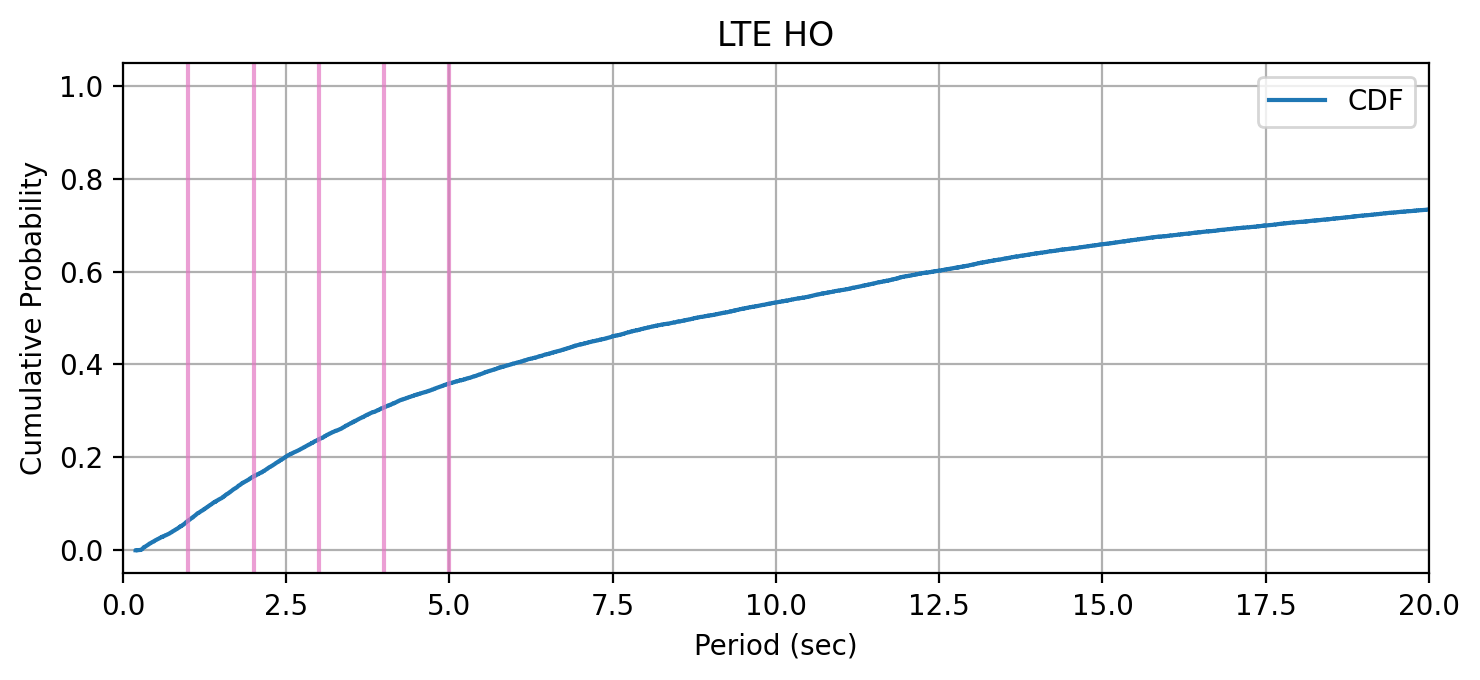

[7.45438, 0.908713, 5.898425, 5.96394, 8.224991, 6.850395, 3.488955, 9.666631, 1.878988, 1.696478, 5.09252, 23.332544, 6.503645, 56.883303, 13.090647, 9.600546, 51.476068, 8.557657, 21.401536, 2.028724, 4.805567, 2.233687, 8.544708, 95.06238, 27.111859, 3.384744, 24.412723, 0.05036, 17.520196, 47.92391, 2.489454, 12.855446, 54.052583, 7.448738, 0.048462, 19.238958, 25.308761, 6.598737, 8.209715, 9.992694, 6.325478, 12.7277, 13.101871, 1.532626, 4.433907, 4.513909, 12.789801, 0.127839, 0.881412, 26.627024, 14.982979, 7.16376, 55.063524, 76.113553, 5.875748, 1.606309, 25.047253, 2.740052, 4.048678, 3.42445, 14.780764, 52.186659, 1.912652, 12.822609, 52.692549, 7.675955, 0.052413, 20.427591, 36.788678, 11.212526, 208.448481, 6.516264, 7.007552, 6.727758, 27.792759, 16.006485, 6.965929, 54.649651, 39.395927, 0.386608, 18.712228, 8.142694, 6.321543, 4.845767, 3.504742, 28.094261, 1.967645, 4.746845, 10.897518, 3.174407, 6.729709, 2.881474, 24.684732, 4.765476, 20.008008, 40.98472, 2.229403,

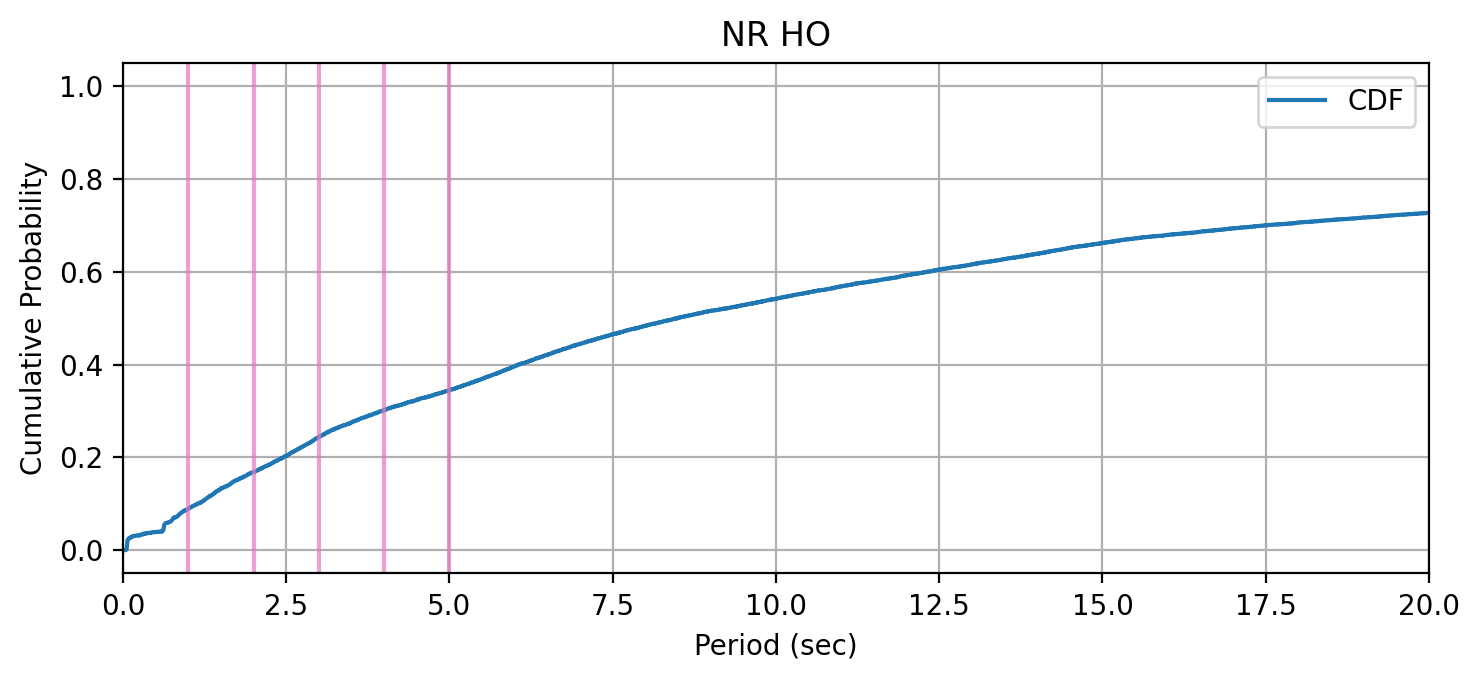

[28.548352, 8.807714, 100.37119, 64.916653, 46.442616, 17.24035, 73.320432, 45.993654, 41.576257, 24.488881, 167.852439, 65.355455, 136.883547, 40.626103, 3.721146, 3.695943, 30.484318, 11.755695, 128.686623, 28.205921, 129.046363, 71.596718, 39.271726, 10.299721, 33.180483, 7.820525, 0.278918, 62.958684, 48.420413, 16.513474, 72.454805, 40.865013, 4.40497, 0.420936, 33.165322, 7.487124, 9.192142, 45.243875, 106.512543, 19.36859, 12.703061, 67.558754, 65.579571, 111.983419, 4.198235, 14.462342, 26.105393, 10.871975, 14.740045, 45.144256, 126.300141, 114.18014, 125.440268, 3.648563, 4.314778, 3.491967, 50.230486, 98.457386, 261.699936, 240.010106, 51.559217, 3.472723, 115.062508, 62.16506, 247.302662, 3.960047, 49.320929, 49.951397, 0.490997, 262.387565, 68.823932, 135.483631, 26.07241, 6.701865, 16.67186, 16.691861, 35.893842, 8.56983, 65.354059, 98.362894, 65.538899, 19.220821, 21.582284, 159.181269, 63.843173, 91.480389, 22.863073, 23.621922, 182.245374, 71.697415, 9.248491, 102.0245

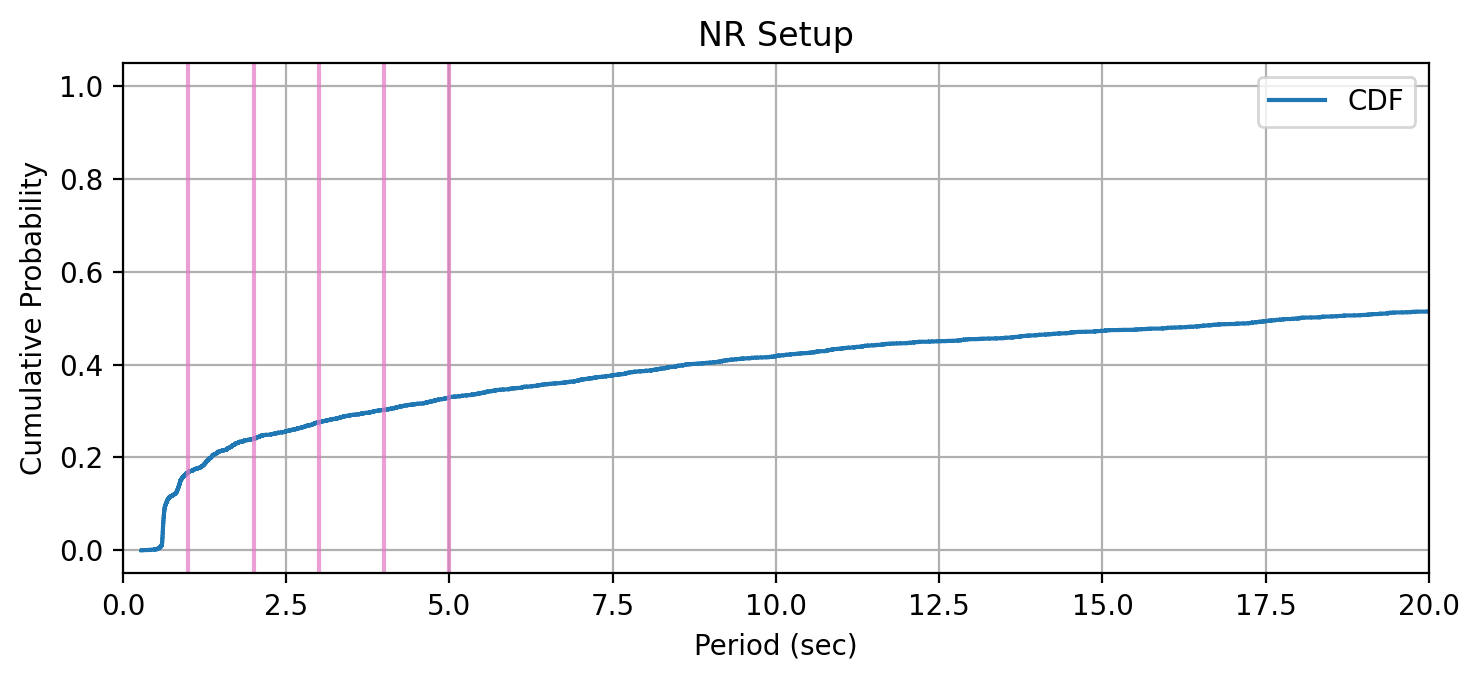

[4.061099, 8.356095, 1.746858, 11.286821, 6.460084, 10.809781, 12.370008, 46.423798, 17.208866, 119.124795, 6.948464, 167.718312, 177.686421, 3.633119, 3.52778, 11.725951, 128.834424, 111.072633, 10.078099, 6.892787, 1.319389, 48.085578, 16.592794, 113.404721, 4.236768, 8.903813, 152.201749, 19.304554, 65.379834, 112.145763, 3.998879, 11.114943, -0.075078, 13.769936, 0.270977, 0.272766, 171.340701, 125.168611, 3.327776, 4.801708, 3.243835, 2.573721, 180.571962, 3.821738, 136.246329, 15.982832, 44.674818, 65.458744, 19.421145, 180.719862, 63.964644, 91.430943, 22.643876, 23.590714, 182.377708, 71.661891, 110.960683, 17.843128, 63.963839, 91.184798, 20.15706, 65.651539, 119.770679, 44.932964, 6.422817, 44.26672, 6.832103, 17.37604, 177.722066, 3.340267, 185.509627, 49.070865, 0.599806, 133.267782, 10.337792, 9.832765, 5.323839, 5.787079, -0.075082, 3.013834, 10.622786, 18.846718, 120.641582, 6.298912, 185.863489, 140.479569, 18.575979, 175.927462, 17.108131, 185.257625, 180.17557, 11.666

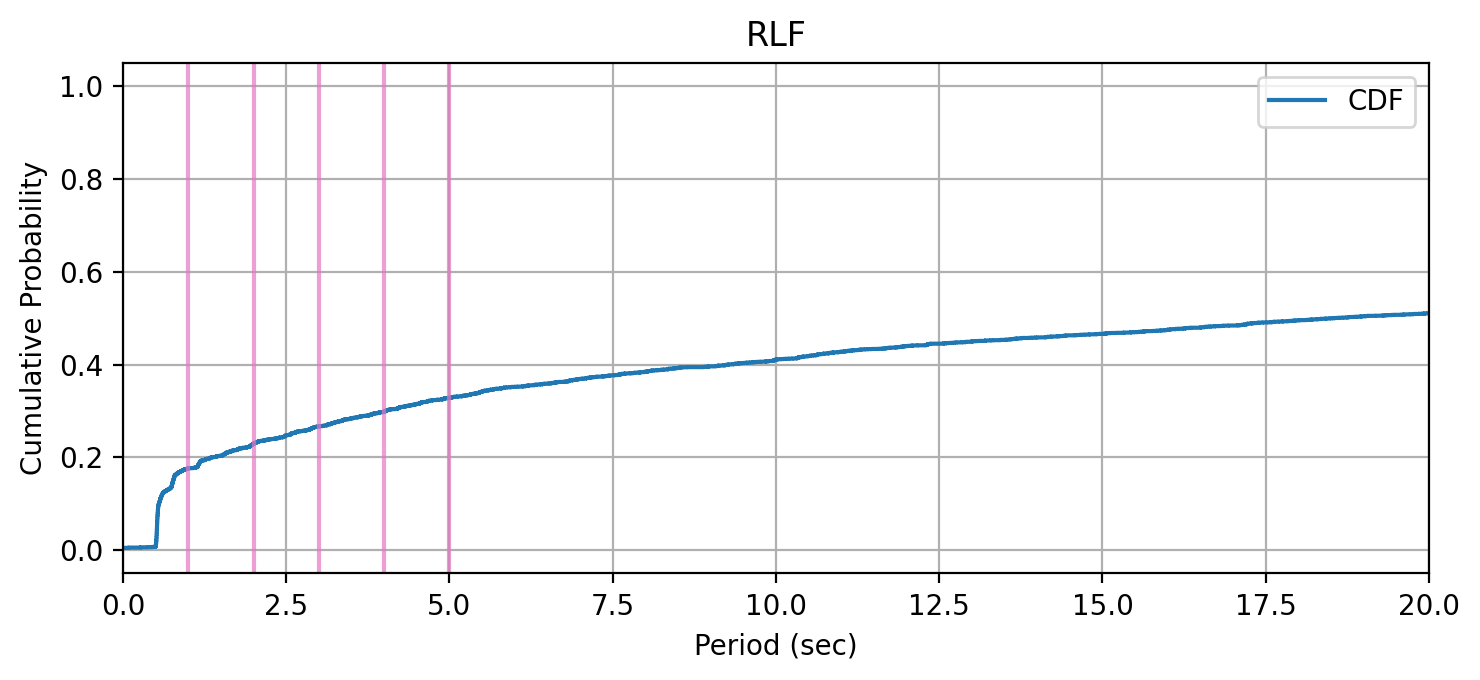

In [76]:
import numpy as np
import matplotlib.pyplot as plt

for category, key in zip([LTE_HO, NR_HO, NR_Setup, RLF], ['LTE_HO', 'NR_HO', 'NR_Setup', 'RLF']):
    title = ' '.join(key.split('_'))
    print(Period[key])
    
    # Sample data (replace this with your list of numbers)
    data = Period[key]

    # Calculate the CDF
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

    # Create a Figure and Axes
    fig, ax = plt.subplots()

    # Plot the CDF
    ax.step(sorted_data, cdf, label='CDF')
    plt.xlabel('Period (sec)')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title(title)
    ax.set_xlim(0, 20)
    ax.axvline(1, color='tab:pink', alpha=0.7)
    ax.axvline(2, color='tab:pink', alpha=0.7)
    ax.axvline(3, color='tab:pink', alpha=0.7)
    ax.axvline(4, color='tab:pink', alpha=0.7)
    ax.axvline(5, color='tab:pink', alpha=0.7)
    ax.legend()
    ax.grid(True)

    # Show the plot
    plt.show()